<h1 style='text-align:center; font-weight:bold; color: orange'>Evaluating Marketing Campaign Effectiveness for New Menu Items: An A/B Testing Approach</h1>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew, kurtosis, kstest, shapiro 
from scipy.stats import levene
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn 
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
plt.style.use('ggplot')

## **1 Introduction**
In today's competitive fast-food industry, choosing effective marketing strategies play crucial roles in maximizing the impact of new product launch on sales. Recently, a fast-food chain launched three different campaigns to promote its new menu items in 137 locations, selected randomly, in four weeks for a trial phase. Based on this experiment, the Marketing Manager aims to identify which promotional campaign should be chosen for the larger scale campaign. The ideal result is a campaign which can generate the largest amount of sales during the testing phase.

Due to the criticality of the decision for selecting the most optimal campaign to promote new menu items, the challenge here is to find which campaign generated the highest sale in the experiment phase. For this reason, a systematic approach to evaluate performance of marketing campaign is crucial for a successful product launch. My goal in this project is to evaluate the effectiveness of three marketing campaigns in promoting new menu items by comparing the sales performance of each campaign to determine which promotion received the highest sales.

Additionally, for clarity purposes, below is the null hypothesis ($H_0$) and the alternative hypothesis ($H_1$) in this project.
- Null hypothesis ($H_0$): There is no significant difference in sales performance across three marketing campaigns. Therefore, any observed differences in sales are due to random chance.
- Alternative hypothesis ($H_1$): There is a significant difference in sales performance across the three promotional campaigns. At least one campaign generates different sales (maybe highest or lowest) compared to the other two.

The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test). This dataset contains information about marketing campaign captured via IBM Watson Analytics. It consists of seven columns but two variables will be mainly used for this project, namely `Promotion` and `SalesInThousands`, to achieve the objective.
- `MarketingID`: unique identifier for market
- `MarketSize`: size of market area by sales
- `LocationID`: unique identifier for store location
- `AgeOfStore`: age of store in years
- `Promotion`: one of three promotions that were tested
- `Week`: one of four weeks when the promotions were run
- `SalesInThousands`: sales amount for a specific location, promotion, and week

## **2 Data Preparation**
This section deals with data preparation, including data cleaning. This broad term "data cleaning" covers whether there are missing values, how many the duplicates are, and how many unique values are. These will be required because the cleanliness of the dataset will affect the trustworthiness of the conclusions drawn from this A/B test.

In [2]:
# load dataset
df = pd.read_csv("../data/Watson_Marketing_Campaign.csv")

In [3]:
# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
    print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

# inspect df
inspect_dataframe(df)

The dataframe contains 548 rows and 7 cols.
- 6 are numeric cols
- 1 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValue,Sample
0,MarketID,548,int64,0.0,0.0,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
1,MarketSize,548,object,0.0,0.0,3,"[Medium, Small, Large]"
2,LocationID,548,int64,0.0,0.0,137,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 10..."
3,AgeOfStore,548,int64,0.0,0.0,25,"[4, 5, 12, 1, 10, 15, 6, 22, 8, 19, 11, 13, 3,..."
4,Promotion,548,int64,0.0,0.0,3,"[3, 2, 1]"
5,week,548,int64,0.0,0.0,4,"[1, 2, 3, 4]"
6,SalesInThousands,548,float64,0.0,0.0,517,"[33.73, 35.67, 29.03, 39.25, 27.81, 34.67, 27...."


**Note**
- As described earlier, the dataset consists of 7 columns (6 numeric columns and 1 object columns) and 548 rows.
- This dataset is quite clean as there are no duplicates and missing values so no further cleaning will be required. If there are duplicates found, there is only one treatment, i.e., removal. But for missing values, the treatment will not be straightforward, e.g., direct removal, depending on the mechanism of missingness.
- Moreover, as this project is mainly interested in seeking which promotional campaign performs better at generating sales, column `Promotion` will be the primary interest. This will be the main column for grouping. And as can be seen, this column contains three unique values, namely `1`, `2`, and `3`, representing each campaign.
- Because this dataset is clean enough, an exploratory data analysis, particularly to check parametric assumptions, can be done. Parametric assumptions is a collection of assumptions or conditions for statistical tests to satisfy. If one or more assumptions are violated, the conclusions drawn from the test results will be invalid. For example, using a one-way ANOVA (analysis of variance) test will be misleading if the assumptions, e.g., normal distribution, homoscedasticity, and independence of observation, are not met. For this reason, other options such as Kruskal-Wallis test, Welch's ANOVA, or Friedman test.
    - Just an additional note, Kruskal-Wallis is a non-parameteric counterpart of one-way ANOVA when the independent groups being compared is more than 2. The term "non-parametric" means that this statistical test does not assume parametric assumptions.
    - Welch's ANOVA is a variation of ANOVA with an adjustment in equal variances between groups (homoscedasticity). While the assumption of homoscedasticity is okay to be violated, this test remains assuming normality of data distribution.
    - Friedman test is more suitable for repeated measures. This is a non-parametric alternative when the parametric assumptions are not met. 

## **3 Parametric Assumption Tests**
The main focus of this exploratory data analysis is to understand whether variable `SalesInThousand` grouped by `Promotion` meets the parametric assumptions such as normality of data distribution, independent observation, and equal variances between groups. Before moving forward to testing each parametric assumption, one question might arise: Why do we bother to check parametric assumptions, not directly choose a non-parametric test which does not assume normal distribution?

Unlike their parametric counterparts, non-parametric tests have some limitations such as less power, rank-based calculation, and lack of informativeness. Nonparametric tests usually have less statistical power to detect actual difference between groups when the sample size is small. Dissimilar to parametric tests relying calculations on the values themselves, nonparametric tests normally depend on ranks. As a consequence, a loss of information can occur here. Last but not least, the calculation of non-parametric tests rely on median as the measure of central tendency. While median itself is useful to inform the middle value in the data distribution, median does not take into account the magnitude of every value in the data.

### **3.1 Are sales by promotions normally distributed?**
This first question deals with the normality of data distribution which can be tested both visually and numerically. Visually, normality can be examined by exploiting a histogram, a boxplot, or a quantile-quantile plot. Here, I will use a raincloud plot, a modification of a histogram and a boxplot. This plot also displays every single point in the dataset. The advantage of this visual test is that we can get the advantages of three types of data visualization techniques in one plot such as clearer examination on data shape and distribution, including central tendency, skewness, kurtosis, and presence of outlier.

As the best practice of normality test is both providing the visual and numerical tests, we also include the numerical tests such as kurtosis, skewness, Kolmogrov-Smirnov, and Shapiro-Wilk test. Kurtosis and skweness test inform us the shape of the distribution numerically. In the interpretations, kurtosis displays the peakness of a distribution. Positive kurtosis (leptokurtic) indicates a sharp peak, and negative kurtosis (platykurtic) shows the distribution has a flatter peak. Furthermore, both Shapiro-Wilk test and Kolmogorov-Smirnov test are used to tell how well data fits a specific distribution and provide *p*-values to interpret the results. The combination of the two tests provides a more comprehensive assessment. If both tests failt to reject the null hypothesis at $alpha$ at 0.05, the data does not fit the normal distribution.

In [4]:
# convert num to string for better readings
df['Promotion'] = df["Promotion"].replace({1: 'Promotion 1', 2: 'Promotion 2', 3: 'Promotion 3'})
df["Promotion"].unique()

array(['Promotion 3', 'Promotion 2', 'Promotion 1'], dtype=object)

**Note**
- For better readability, the numerical values in `Promotion` were converted into strings by adding "Promotion" at the beginning.
- Moreover, as there are three groups in the variable, some options for testing the group differences are one-way ANOVA test and Kruskal-Wallis test. In general, they shared a common purpose: Both statistical test test differences between more than 2 independent groups with a null hypothesis of all groups having the same mean (for one-way ANOVA) or distribution (Kruskal-Wallis). However, as mentioned earlier, one-way ANOVA is a parametric test while Kruskal-Wallis is non-parametric.

In [28]:
# create function to apply normality tests
def test_normality(group):
    return pd.Series({
        'skewness': skew(group),
        'kurtosis': kurtosis(group),
        'ks_pvalue': kstest(group, 'norm').pvalue,
        'sw_pvalue': shapiro(group).pvalue
    })

# apply the normality tests
(df.groupby('Promotion')['SalesInThousands']
 .apply(test_normality)
 .to_frame()
 .rename(columns={'SalesInThousands':'Value'})
 .round(4))

Value
Promotion                    
Promotion 1 skewness   0.8585
            kurtosis   0.0284
            ks_pvalue  0.0000
            sw_pvalue  0.0000
Promotion 2 skewness   0.9205
            kurtosis   0.6614
            ks_pvalue  0.0000
            sw_pvalue  0.0000
Promotion 3 skewness   0.7642
            kurtosis  -0.1787
            ks_pvalue  0.0000
            sw_pvalue  0.0000

**Note**
- All sales data by promotions deviate from normal distribution with positive skewness, indicating the presence of a few high sales figures in each promotion which affect the overall distribution.
- Moreover, the normality tests also indicate non-normal distributions. For example, with *p* = 0.0000 on Shapiro-Wilk test, the amount of sales generated by `Promotion 1` is significantly different from a normal distribution.
- Given the non-normality, non-parametric methods might be more appropriate for statistical analysis for the sales data.

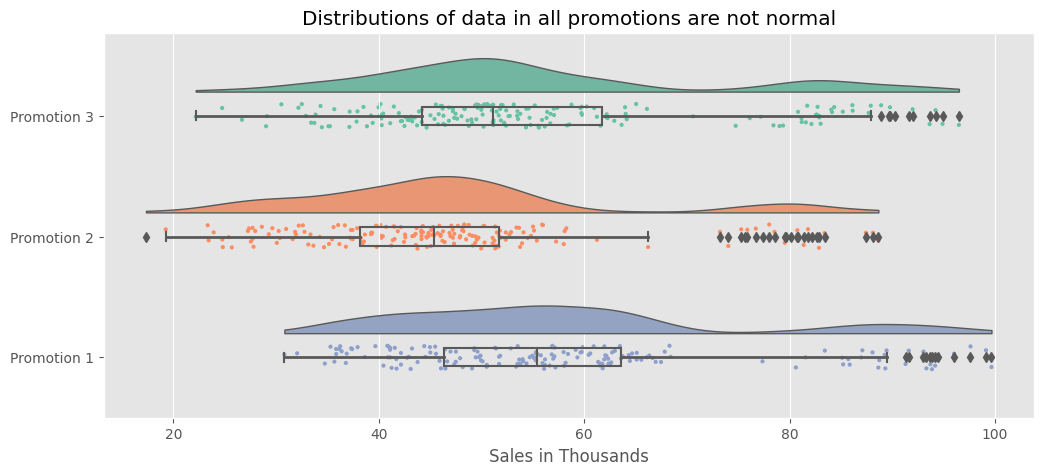

In [6]:
# set up the figure
plt.figure(figsize=(12, 5))

# use raincloud to display distribution
pt.RainCloud(x='Promotion', y='SalesInThousands', data=df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h')
plt.title('Distributions of data in all promotions are not normal')
plt.xlabel('Sales in Thousands')
plt.ylabel(None)
plt.show()

**Note**
- All promotions in terms of sales indicate non-normal distributions, in line with the previous findings in Section 3.1.1 (numerical test).
- As can be seen all promotions appear to be positively skewed since the majority of data are located on the left and some are on the right of the distribution. This kind of skewness, judging solely from the histogram in the raincloud plot, indicates the presence of outliers which can be further examined from data points beyond the lower and upper whisker of the boxplots.
- To extend our understanding on the outliers, we can use interquartile range (IQR) based outlier detection to quantify the outliers.

In [7]:
# create function to detect outliers using IQR
def detect_outliers(df, column, category):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{category}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

# apply the function to each group
df.groupby('Promotion').apply(lambda x: detect_outliers(x, 'SalesInThousands', x['Promotion'].iloc[0]))

The number of outliers in 'Promotion 1' is 12 or 6.98% of the total data (172 rows).
The number of outliers in 'Promotion 2' is 24 or 12.77% of the total data (188 rows).
The number of outliers in 'Promotion 3' is 10 or 5.32% of the total data (188 rows).


""


**Note**
- The code above computed the number and rate of outliers in each promotion. 
- `Promotion 2` appear to have the highest number of outliers, constituting 24 points (12.77%).
- `Promotion 1` and `Promotion 3`, on the other hand, have similar rate of outliers (6.98 vs 5.32%).
- While this finding does not significantly adds information about the distribution, in addition to providing the number of outliers, this finding also guides us to select a statistical test which is more robust to outliers.

### **3.2 Are the variances of sales by promotions equal?**
Homogeneity of variance is tested because some tests, especially a one-way ANOVA test, require us to meet this criteria. To test this assumption, I rely on Levene's test (Levene, 1960) with a null hypothesis of equal variances in the groups (`Promotion 1`, `Promotion 2`, and `Promotion 3`). For this reason, if the *p*-value is less than 0.05, the decision is to reject the $H_0$ and the assumption of equal variances across promotional campaigns is violated. 

But before doing the more formal inspection using Levene's test, I will firstly check the spread of data in each group numerically using variances. This initial inspection will provide a numerical sense of the data spread in each promotional campaign.

In [8]:
# get variance of each group
df.groupby('Promotion')['SalesInThousands'].var().reset_index(name='Variance').round(3)

,Promotion,Variance
0,Promotion 1,274.028
1,Promotion 2,228.281
2,Promotion 3,281.106


**Note**: 
- The variances ($s^2$) in `Promotion 1` and `Promotion 3` are similar, indicating similar variability in these groups. Variance for `Promotion 2`, on the other hand, is lower than the other two although the difference is not large. From these variances, it is possible that the assumption of homoscedasticity will be met. 
- One important question here maybe why we still need to use Levene's test to assess homogeneity of variances while variances of each promotional campaign can be computed and compared.
- One reason is about how they work. Variance indeed can give a sense of how data in different campaigns is distributed but variance is sensitive to outliers since it uses sample mean ($\bar{x}$). When there are outliers and/or the distribution is not normal, variance may not be a good choice to evaluate the homogeneity of variances. 
    - To note, the distributions of all campaigns are not normal and they contain outliers.
- Levene's test, on the other hand, is more robust when the distibution is not perfectly normal or small sample size ([Nordstokke & Colp, 2014](https://www.uv.es/revispsi/articulos2.14/10NORDSTOKKE.pdf)). 

In [9]:
# creating separate arrays for each promotion
sales_promo1 = df[df['Promotion'] == 'Promotion 1']['SalesInThousands']
sales_promo2 = df[df['Promotion'] == 'Promotion 2']['SalesInThousands']
sales_promo3 = df[df['Promotion'] == 'Promotion 3']['SalesInThousands']

# performing Levene's test
levene_stat, p_value = levene(sales_promo1, sales_promo2, sales_promo3)

In [10]:
# display output
pd.DataFrame({
    'Test': ['Levene\'s Test'],
    'Test Statistic': [levene_stat],
    'p-value': [p_value],
    'Conclusion': ['Variances are significantly different' if p_value < 0.05 else 'Variances are not significantly different']
})

,Test,Test Statistic,p-value,Conclusion
0,Levene's Test,1.269679,0.281751,Variances are not significantly different


**Note**: From the Levene's test output, the variances across three different marketing campaigns were similar (*F* = 1.269, *p* = 0.281).Based on *p* > 0.05, the assumption of homogeneity of variances is tenable.

### **3.3 Are there any potential measurement errors?**
This section is concerned with checking whether there are weird values in the dataset. For example, the number of weeks within a month is not possible for either negative integer or greater than 4. However, since our main interest is column `Promotion` and `SalesInThousand`, other columns will not be investigated further.

In [11]:
df.describe().round()

,MarketID,LocationID,AgeOfStore,week,SalesInThousands
count,548.0,548.0,548.0,548.0,548.0
mean,6.0,480.0,9.0,2.0,53.0
std,3.0,288.0,7.0,1.0,17.0
min,1.0,1.0,1.0,1.0,17.0
25%,3.0,216.0,4.0,2.0,43.0
50%,6.0,504.0,7.0,2.0,50.0
75%,8.0,708.0,12.0,3.0,60.0
max,10.0,920.0,28.0,4.0,100.0


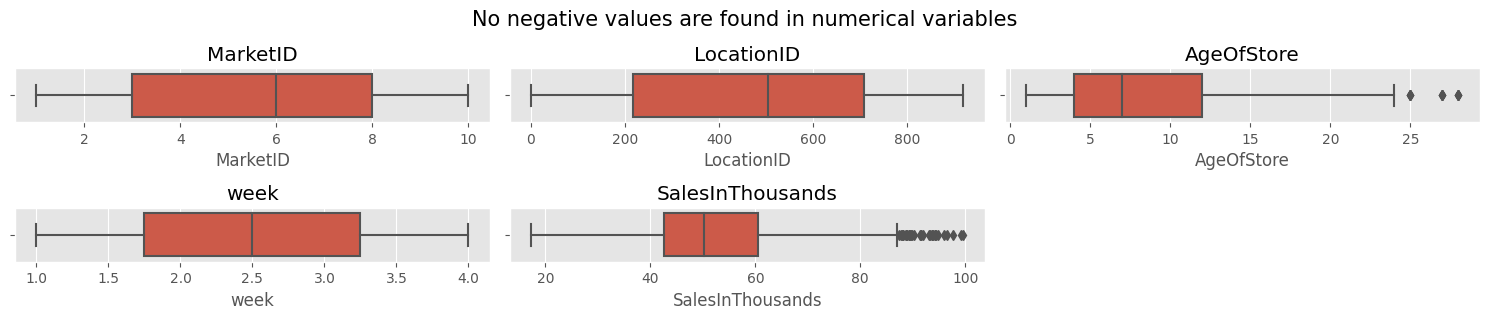

In [12]:
# specify columns to plot
numerical_columns = df.select_dtypes(include='number')

# setup up figure size
plt.figure(figsize=(15, 7))

# create boxplots
for i, col in enumerate(numerical_columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'{col}')
plt.suptitle('No negative values are found in numerical variables', size=15)
plt.tight_layout()
plt.show()

**Note**
- While the data type of `MarketID` and `LocationID` is numeric, examining potential measurement errors in these columns are not done because these columns only serve to indicate unique identifier of each observation, not the measurement itself.
- Column `AgeOfStore`, `week`, and `SalesInThousand` do not seem to contain any measurement errors since the values are possible in real-worldd.

### **3.4 Summary**
Before moving forward to the statistical analysis, the central part of this A/B test, I will recapitulate the key findings on the parametric assumption tests in Section 3 to better inform which statistical test is best-suited for the testing. In short, the distributions of all sales by promotions are not normal. Outliers are also present in sales based on promotions. Additionally, it is not possible to move forward with one-way independent ANOVA since the homoscedasticity assumption is also violated based on Lavene's test output. For these reasons, Kruskal-Wallis test will be used.

## **4 Statistical Analysis**
In this section, Kruskal-Wallis H test will be carried out to check the overall differences between sales by promotions. This test will be proceeded by Dunn's post-hoc test to examine specific group difference if the Kruskal-Wallis test output is significant. Since these tests can only provide a half story of the group difference (promotional campaign difference in terms of sales), effect size ($\eta^2$) for Kruskal-Wallis *H* will be computed. Last, the analysis will be supplied by computation of confidence intervals for the effect size.

### **4.1 Perform Kustkal-Wallis *H* Test**

In [13]:
# separate data by groups
sales_promo1 = df[df['Promotion'] == 'Promotion 1']['SalesInThousands']
sales_promo2 = df[df['Promotion'] == 'Promotion 2']['SalesInThousands']
sales_promo3 = df[df['Promotion'] == 'Promotion 3']['SalesInThousands']

# number of groups
num_groups = 3

# Perform Kruskal-Wallis H test
h_stat, p_value = kruskal(sales_promo1, sales_promo2, sales_promo3)

# Degrees of freedom
dof = num_groups - 1

# Print Kruskal-Wallis H Test results
print(f"Kruskal-Wallis H Test statistic:")
results = pd.DataFrame({
    'H': [h_stat],
    'p-value': [p_value],
    'dof': [dof],
    'significant': [p_value < 0.05]
})

results.round(4)

Kruskal-Wallis H Test statistic:


,H,p-value,dof,significant
0,53.2948,0.0,2,True


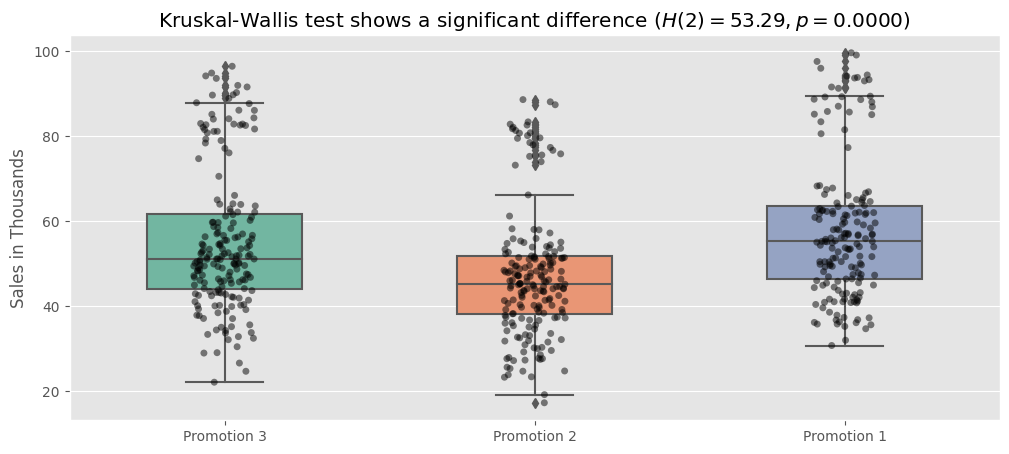

In [14]:
plt.figure(figsize=(12, 5))

# create boxplot 
sns.boxplot(x='Promotion', y='SalesInThousands', data=df, palette='Set2', width=0.5)
sns.stripplot(x='Promotion', y='SalesInThousands', data=df, color='k', alpha=0.5, jitter=True)
plt.title(f'Kruskal-Wallis test shows a significant difference ($H({dof})={h_stat:.2f}, p={p_value:.4f})$')
plt.xlabel(None)
plt.ylabel('Sales in Thousands')
plt.show()

**Note**
- The Kruskal-Wallis test indicates a significant difference in sales based on promotional campaigns (*H*(2) = 53.29, *p* = 0.00).
- As mentioned earlier, Kruskal-Wallis test can only check the overall difference between groups. To identify whether the differences between each group (promotional campaign), a post-hoc test will be required. Dunn's test for a pairwise comparison will be used.

### **4.2 Perform Dunn's Post-Hoc Test**
Dunn's test ([Dunn, 1964](https://doi.org/10.1080/00401706.1964.10490181)) here is used as a post-hoc pairwise comparison test between promotional campaigns in terms of sales. Probability (*p*) value needs to be adjusted to prevent obtaining a difference between a promotional campaign pair by random chance (hereby, reducing the risk of a false positive). Holm's method ([Holm, 1979](https://www.jstor.org/stable/4615733)) is adopted to control the [family-wise error rate](https://www.statology.org/family-wise-error-rate/) (FWER).

In [15]:
# separate data by groups
sales_promo1 = df[df['Promotion'] == 'Promotion 1']['SalesInThousands']
sales_promo2 = df[df['Promotion'] == 'Promotion 2']['SalesInThousands']
sales_promo3 = df[df['Promotion'] == 'Promotion 3']['SalesInThousands']

# perform Dunn's test
dunn_results = posthoc_dunn([sales_promo1, sales_promo2, sales_promo3], p_adjust='holm').round(4)

display(dunn_results)

,1,2,3
1,1.0000,0.0,0.0486
2,0.0000,1.0,0.0000
3,0.0486,0.0,1.0000


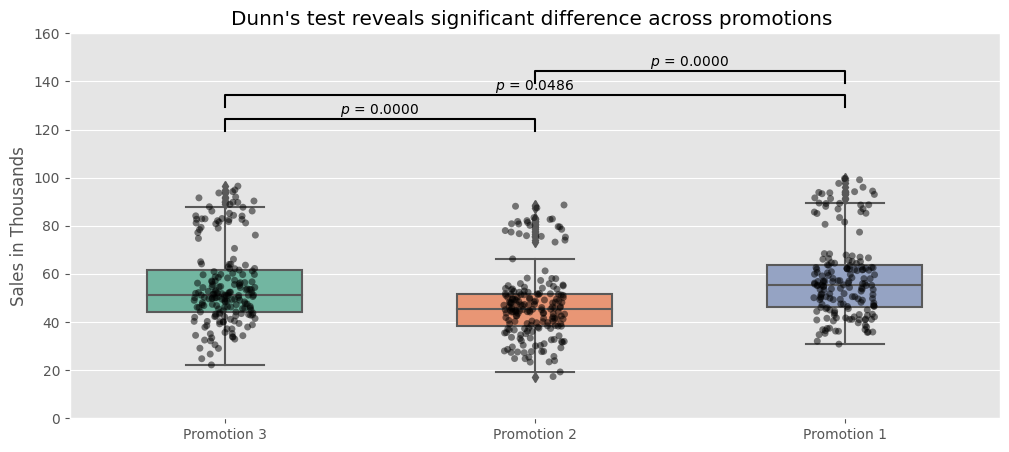

In [16]:
# set up the figure
plt.figure(figsize=(12, 5))

# create the boxplot with data points
sns.boxplot(x='Promotion', y='SalesInThousands', data=df, palette='Set2', width=0.5)
sns.stripplot(x='Promotion', y='SalesInThousands', data=df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(df['SalesInThousands'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# extract unique promotions for easy indexing
promotions = df['Promotion'].unique()
promotions_dict = {promo: idx for idx, promo in enumerate(promotions)}

# plot Dunn's test results
for i, promo1 in enumerate(promotions):
    for j, promo2 in enumerate(promotions):
        if i < j:
            p_value = dunn_results.iloc[i, j]
            if p_value < 0.05:
                # determine positions for the bracket
                x1, x2 = promotions_dict[promo1], promotions_dict[promo2]
                y = max_y + offset * (i + j + 1)    # vertical position of the bracket
                h = offset * 0.5                    # height of the bracket
                col = 'k'                           # color of the line and text

                # add a bracket-style line indicating significant difference
                plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
                # add a label for the p-value
                plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title('Dunn\'s test reveals significant difference across promotions ')
plt.ylim(0, 160)
plt.xlabel(None)
plt.ylabel('Sales in Thousands')
plt.show()

**Note**
- The results show significant differences between all pairs of groups, given that all p-values are less than 0.05.
    - `Promotion 1` vs `Promotion 2`: *p* = 0.00
    - `Promotion 2` vs `Promotion 3`: *p* = 0.00
    - `Promotion 1` vs `Promotion 3`: *p* = 0.04
- While other pairs indicate strongly signficant differences, the probability value of the `Promotion 3` and `Promotion 1` pair is only slightly below the alpha ($\alpha$).

### **4.3 Compare Median Sales**
While we already obtained Kruskal-Wallis H and Dunn's test outputs to examine whether the differences between promotional campaigns are statistically significant, we have not explicitly test which campaign outperforms others in terms of sales. For this reason, I will use median to indicate the best performing campaign. In its interpretation, the promotion with the highest median is the best in terms of its performance.

In [17]:
median_promotion =( df.groupby('Promotion', as_index=False)
                   .agg(func={'SalesInThousands':'median'})
                   .sort_values(by='SalesInThousands', ascending=False))
median_promotion

,Promotion,SalesInThousands
0,Promotion 1,55.385
2,Promotion 3,51.165
1,Promotion 2,45.385


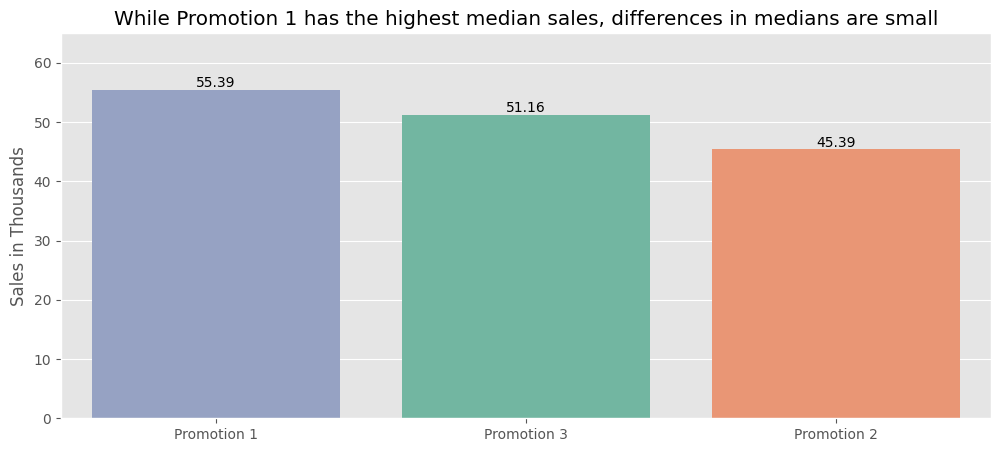

In [24]:
plt.figure(figsize=(12, 5), dpi=100)
# create barplot
colors = {'Promotion 1': '#8e9fca', 'Promotion 2': '#fc8d62', 'Promotion 3':'#66c2a5'}
ax = sns.barplot(x='Promotion', y='SalesInThousands', data=median_promotion, palette=colors)

# add data labels
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
plt.title('While Promotion 1 has the highest median sales, differences in medians are small')
plt.ylim(0, 65)
plt.ylabel('Sales in Thousands')
plt.xlabel(None)
plt.show()

**Note**
- In general, the median sales of Promotion 1 is the highest (USD 55.39) among two other campaigns.
- But since the median of each campaign is close from one to another, the differences in median sales across different promotional campaigns do not seem to be large (USD4.23K for `Promotion 1` vs `Promotion 2`; USD 10K for `Promotion 1` vs `Promotion 3`; and USD 5.76K for `Promotion 2` vs `Promotion 3`.
- For this reason, the significant differences found previously should be interpreted with caution, and to examine the practical significance of the differences, I will use effect size ($\eta^2$) for Kruskal-Wallis test statistic.

### **4.4 Confidence Intervals and Effect Size**
Confidence intervals (CIs) allows us to evaluate a range within which we can be confident that the true mean difference lies. And effect size quantifies the magnitude of difference between groups, not just whether the difference is statistically significant.

The confidence intervals here are used to understand the precision of the estimates and effect sizes to understand the practical significance. So it gives context to the statistical significance in the real-world impact of the difference. Effect size used here is eta-squared ($\eta^2$), measuring the proportion of variance explained by promotions in the data (see [rstatix 0.7.2](https://rpkgs.datanovia.com/rstatix/reference/kruskal_effsize.html#:~:text=Compute%20the%20effect%20size%20for,the%20total%20number%20of%20observations.) for the R documentation).

$$\eta^2 = \frac{H - k + 1}{n - k}$$
- $H$: Kruskal-Walllis test statistic
- $k$: number of campaigns
- $n$: sample size

In [19]:
# define grouped data
grouped_data = [sales_promo1, sales_promo2, sales_promo3]

# specify k and n
k = len(grouped_data)
n = sum([len(group) for group in grouped_data])

# calculate eta-squared
eta_squared = (h_stat - k + 1) / (n - k)
print(f"Eta-squared: {eta_squared:.4f}")

Eta-squared: 0.0941


**Note**: As eta-squared ($\eta^2$) represents the proportion of variance in sales (`SalesInThousands`) that is explained by promotional campaigns (`Promotion`), the effect size ($\eta^2$) means only 9.4% of the variance in sales is explained by the differences between promotional campaigns.

In [20]:
# bootstrapping for confidence intervals
n_bootstraps = 1000
bootstrapped_eta_squared = []

for _ in range(n_bootstraps):
    # resample data with replacement
    resampled_data = [np.random.choice(group, size=len(group), replace=True) for group in grouped_data]
    resampled_H_stat, _ = kruskal(*resampled_data)
    
    # calculate eta-squared for resampled data
    resampled_eta_squared = (resampled_H_stat - k + 1) / (n - k)
    bootstrapped_eta_squared.append(resampled_eta_squared)

# calculate the confidence intervals (e.g., 95% CI)
ci_lower = np.percentile(bootstrapped_eta_squared, 2.5)
ci_upper = np.percentile(bootstrapped_eta_squared, 97.5)

print(f"95% Confidence Interval for eta-squared: [{ci_lower:.4f}, {ci_upper:.4f}]")

95% Confidence Interval for eta-squared: [0.0556, 0.1486]


**Note**: The 95% confidence interval for $\eta^2$, obtained via bootstrapping, was [0.0567, 0.1463]. This interval suggest that the true effect size lies between 5% and 14% of the variance in sales being attributable to the promotional campaigns.

## **5 Conclusions**
### **5.1 Summary**
In brief, this analysis seeks to identify which promotional campaign generated largest sales. Since the data did not meet the assumptions for parametric tests, Kruskal-Wallis H test was adopted along with Dunn's post-hoc test. The results revealed that Promotion 1 had the highest median sales among three campaigns. While these three campaigns were found to be statistically different, the practical significance of their differences is small.
 
Taken altogether, despite finding the significant difference between promotional campaigns, with the Promotion 1 as highest median sales, the practical difference is not big enough. This small impact implies that while the campaigns affect sales, the impact is relatively small to warrant major changes based on these results alone.

### **5.2 Recommendations**
- Although there are differences between promotional campaigns, the impact on sales is not large. As a result, consider reviewing the campaigns to see if there are ways to improve their effectiveness.
- Since the practical differences are small, take into account other factors such as target audience or cost when deciding which campaign to use.

## **6 References**
- Dunn, O. J. (1964). Multiple comparisons using rank sums. *Technometrics*, 6(3), 241-252. https://doi.org/10.1080/00401706.1964.10490181
- Holm, S. (1979). A Simple Sequentially Rejective Multiple Test Procedure. *Scandinavian Journal of Statistics*, 6(2), 65–70. http://www.jstor.org/stable/4615733
- Levene, H. (1960). In *Contributions to Probability and Statistics: Essays in Honor of Harold Hotelling*, I. Olkin et al. eds., Stanford University Press, pp. 278-292.
- Nordstokke, D. W., & Colp, S. M. (2014). Investigating the robustness of the nonparametric Levene test with more than two groups. *Psicológica*, 35(2), 361-383.

<h1 style='color:orange; font-weight:bold; text-align:center'>---END---</h1>